In [95]:
import subprocess
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import copy 
import os
import glob
import warnings
from os.path import join as pjoin

import scipy.io
import nilearn
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain

def mkdir_no_exist(d): os.makedirs(d, exist_ok=True)

from nilearn.plotting import plot_img, plot_glass_brain
import matplotlib.pyplot as plt


# repetition has to be known
TR = 0.72 

In [3]:
def pretty_print(files, n_toprint=None, basepath=False):
    to_print = files
    if n_toprint is not None:
        to_print = to_print[:n_toprint]
    for f in to_print:
        print(os.path.basename(f) if basepath else f)

Note that the data have already been preprocessed (removal of nuosance regressor, coregistration, normalization to mni)

# Task selection



In [8]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)

In [9]:
subject = '113619'
tasktype = 'MOTOR'
acquisition = "RL"

subject_task_prefix = f"{subject}_{tasktype}"

In [10]:
def subject_gm_mask_path(subject):
    return pjoin(anat_dir, f"{subject}_gm_mask.nii.gz")

def subject_task_concat_volumes_path(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fMRIvols.nii.gz")

def subject_task_fmap(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fmap.nii.gz")

In [78]:
def process_gray_matter_mask(anat_dir, subject, border_size=10, save=False, plot=True):
    # Save the 4D image as .nii.gz
    clean_gm_mask_file = subject_gm_mask_path(subject)
    if not os.path.isfile(clean_gm_mask_file):
        warnings.warn(f"mask for {subject} was never extracted")
    print(clean_gm_mask_file)
        
    grey_matter_mask = pjoin(fMRI_dir, subject, 'T1/Atlased/GMmask.nii')

    nifti_image = nib.load(grey_matter_mask)
    mask_data = nifti_image.get_fdata()

    if border_size > 0:
        mask_data[:border_size, :, :] = 0  # Remove borders along the first dimension (x)
        mask_data[-border_size:, :, :] = 0
        mask_data[:, :border_size, :] = 0  # Remove borders along the second dimension (y)
        mask_data[:, -border_size:, :] = 0
        mask_data[:, :, :border_size] = 0  # Remove borders along the third dimension (z)
        mask_data[:, :, -border_size:] = 0

    clean_gm_mask = nib.Nifti1Image(mask_data, affine=nifti_image.affine, header=nifti_image.header)

    if plot:
        # Plot the resampled gray matter mask
        plot_img(grey_matter_mask, title="Subject's Grey Matter Mask", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(15, 4)))
        # Plot the resampled gray matter mask
        plot_img(clean_gm_mask, title="Grey Matter Mask with cleaned borders", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(15, 4)))
    
    # Show the plot
    plt.show()    
    if save:
        nib.save(clean_gm_mask, clean_gm_mask_file)

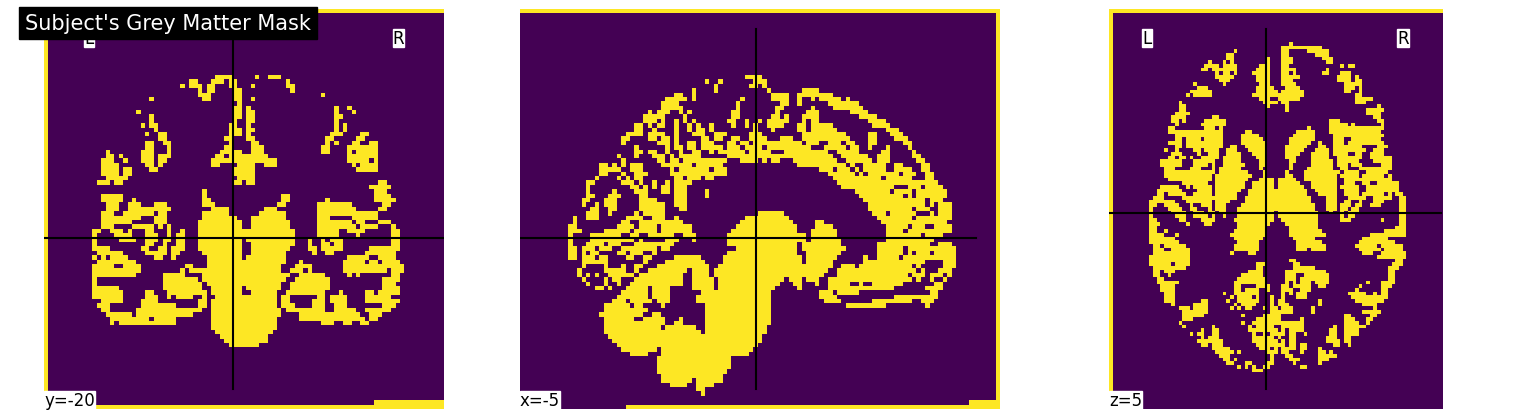

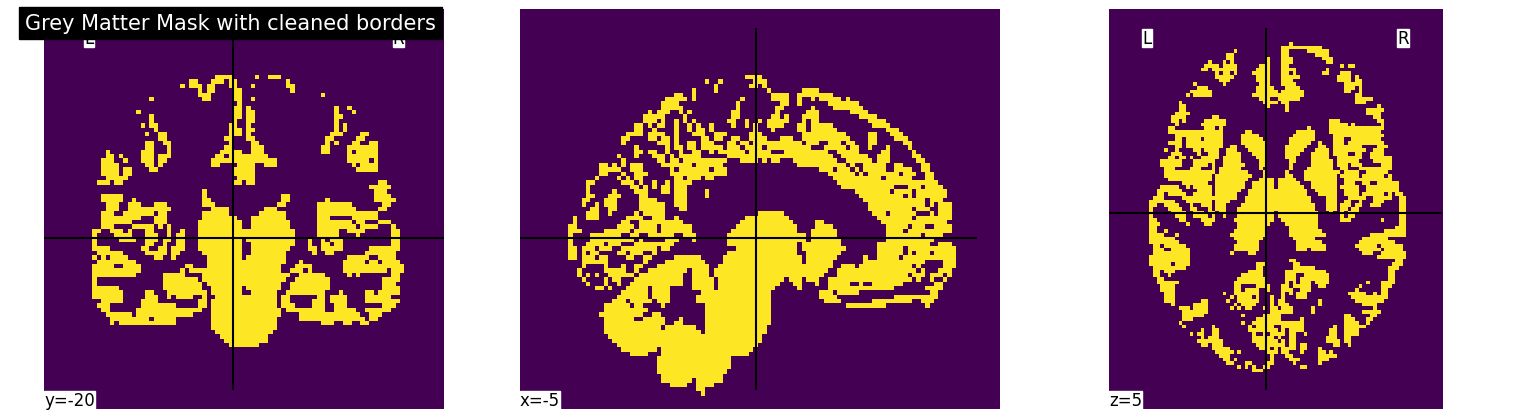

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz


In [12]:
process_gray_matter_mask(anat_dir, subject, border_size=2, save=True)

In [53]:
def create_4d_volume(subject, task, acquisition, smoothing=5, save=False):
    concat_4d_vols_file = subject_task_concat_volumes_path(subject, task, acquisition, smoothing)
    print(concat_4d_vols_file)
    if os.path.isfile(concat_4d_vols_file):
        print(f"files {os.path.basename(concat_4d_vols_file)} already exists, skipping processing")
        return nib.load(concat_4d_vols_file)
    
    nii_directory = os.path.join(fMRI_dir, subject, f"tfMRI_{task}_{acquisition}/fMRIvols_GLMyes/")
    nii_files = sorted(glob.glob(nii_directory + '*.nii'))
    pretty_print(nii_files, n_toprint=2)
    
    first_img = nib.load(nii_files[0])
    data = first_img.get_fdata()  # 3D data from the first file
    data_4d = np.zeros((data.shape[0], data.shape[1], data.shape[2], len(nii_files)))

    for i, nii_file in enumerate(nii_files):
        img = nib.load(nii_file)
        img = image.smooth_img(img, smoothing)
        data_4d[..., i] = img.get_fdata()

    # Create a new NIfTI image
    concat_img = nib.Nifti1Image(data_4d, affine=first_img.affine, header=first_img.header)
    
    if save:
        nib.save(concat_img, concat_4d_vols_file)
        
    return concat_4d_vols_file

In [14]:
create_4d_volume(subject, tasktype, acquisition, smoothing=5, save=True)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing


In [52]:
def create_events_df(subject, task, acquisition, plot_regressors=False):
    filepath = pjoin(paradigm_dir, f"{subject}_Regressor_tfMRI_{task}_{acquisition}.mat")
    print(filepath)
    data = scipy.io.loadmat(filepath)

    regressor = data['Regressor']

    # Flatten the regressor to 1D if necessary
    regressor_flat = regressor.flatten()
    if plot_regressors:
        plt.plot(regressor_flat)
    
    # Initialize lists to store onset, duration, and condition (trial type)
    onsets, durations, trial_types = [], [], []

    # Identify events by iterating through the regressor
    current_condition = regressor_flat[0]
    start_time = 0  # Initial start time
    
    for i, condition in enumerate(regressor_flat[1:], start=1):
        if condition == current_condition: 
            continue

        # Append the onset, duration, and trial type of the previous condition
        onsets.append(start_time * TR)
        durations.append((i - start_time) * TR)
        trial_types.append(f'condition_{current_condition}')

        # Update for the new condition
        current_condition = condition
        start_time = i

    # Add the last event
    onsets.append(start_time * TR)
    durations.append((len(regressor_flat) - start_time) * TR)
    trial_types.append(f'condition_{current_condition}')

    # Create the event file as a DataFrame
    events = pd.DataFrame({
        'onset': onsets,
        'duration': durations,
        'trial_type': trial_types
    })

    #Remove condition 0 which is a the no-paradigm condition and reset indexes
    events = events[events['trial_type'] != "condition_0"]
    events = events.reset_index(drop=True)
    
    condition_counts = events['trial_type'].value_counts().to_dict()
    independent_events = copy.deepcopy(events)
    # Modify the trial_type to include the index of each event occurrence
    independent_events['trial_type'] = [f"{row['trial_type']}_{i}" for i, row in events.iterrows()]
    
    return independent_events

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_WM_RL.mat


onset  duration     trial_type
0    7.92     27.36  condition_5_0
1   36.00     27.36  condition_2_1
2   79.20     27.36  condition_8_2
3  107.28     27.36  condition_1_3
4  150.48     27.36  condition_3_4
5  179.28     27.36  condition_6_5
6  222.48     27.36  condition_4_6
7  250.56     27.36  condition_7_7

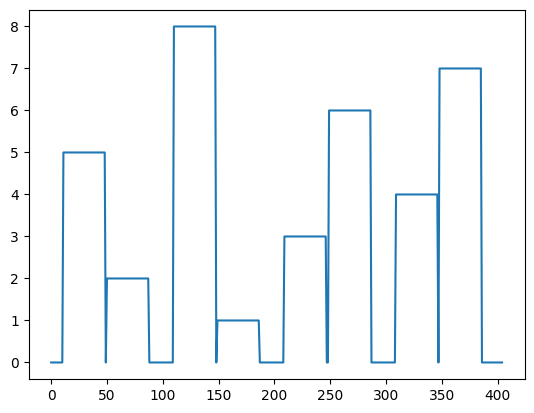

In [16]:
create_events_df(subject, "WM", acquisition, plot_regressors=True)

In [19]:
create_events_df(subject, tasktype, acquisition, plot_regressors=False)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat


onset  duration     trial_type
0   10.80     11.52  condition_4_0
1   25.92     11.52  condition_2_1
2   56.16     11.52  condition_5_2
3   71.28     11.52  condition_1_3
4   86.40     11.52  condition_3_4
5  115.92     11.52  condition_4_5
6  131.04     11.52  condition_5_6
7  146.88     11.52  condition_2_7
8  162.00     11.52  condition_3_8
9  177.12     11.52  condition_1_9

In [97]:
def plot_fmap(fmap, threshold, display_mode, task="", info=None):
    plot_stat_map(
        fmap,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
        figure=plt.figure(figsize=(15, 3)),
        display_mode=display_mode,
        cut_coords=7,
        black_bg=True,
        colorbar=False
    )

In [101]:
def plot_fmap_glass(fmap, threshold, task="", info=None):
    plot_glass_brain(
        fmap,
        display_mode='ortho',
        colorbar=True,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
    )

In [21]:
def compute_task_fmap(subject, task, acquisition, smoothing, fmri_glm, contrast_matrix, save=False):
    fmap_path = subject_task_fmap(subject, task, acquisition, smoothing)
    if os.path.isfile(fmap_path):
        return nib.load(fmap_path)

    f_test_result = fmri_glm.compute_contrast(contrast_matrix, stat_type='F')
    if save:
        f_test_result.to_filename(fmap_path)
    
    return f_test_result

In [99]:
def show_task_activation(subject, task, acquisition, smoothing=5, plot_designmatrix=False, cluster_size=None, fdr_rate=0.01, threshold=2, plot_glass=False):
    print("selecting subject gray matter mask")
    gm_mask = subject_gm_mask_path(subject)
    print(gm_mask)
    
    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)
    
    print("processing event conditions")
    independent_events = create_events_df(subject, task, acquisition)
    
    fmri_glm = FirstLevelModel(
        mask_img=gm_mask,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model='spm',
        drift_model=None, # not necessary, nuisance covariates have already been removed
    )

    # Fit the model to our design and data
    print(f"fitting GLM for task {task}")
    fmri_glm = fmri_glm.fit(fmri_vols, independent_events)
    
    design_matrix = fmri_glm.design_matrices_[0]
    if plot_designmatrix:
        plot_design_matrix(design_matrix)

    n_regressors = design_matrix.shape[1] #non usato per ora

    contrast_matrix = np.diag(np.ones(n_regressors)) 
    contrast_matrix[n_regressors-1, n_regressors-1] = 0 

    contrast_matrix = np.zeros((n_regressors-1, n_regressors))
    np.fill_diagonal(contrast_matrix, 1)  # Identity matrix for joint F-test
    
    print("computing fmap")
    fmap = compute_task_fmap(subject, task, acquisition, smoothing, fmri_glm, contrast_matrix, save=True)
    if cluster_size is not None:
        fmap, threshold = threshold_stats_img(fmap, alpha=fdr_rate, cluster_threshold=cluster_size)
        
    info = {"sub": subject, "smooth": f"{smoothing}mm"}
    if plot_glass:
        plot_fmap_glass(fmap, threshold, task=task, info=info)
    else:
        plot_fmap(fmap, threshold, "z", task=task, info=info)
        plot_fmap(fmap, threshold, "x", task=task, info=info)
        plot_fmap(fmap, threshold, "y", task=task, info=info)
    plt.show()

processing subject gray matter mask
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


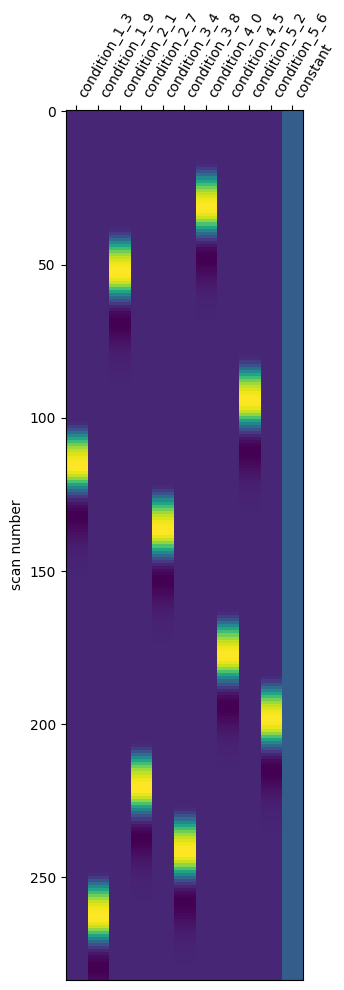

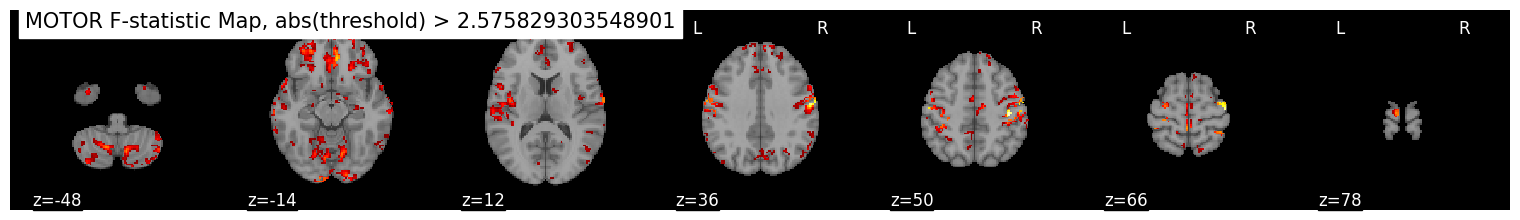

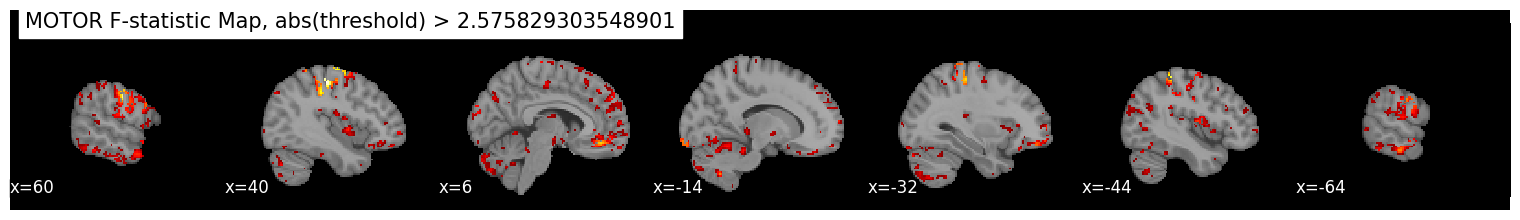

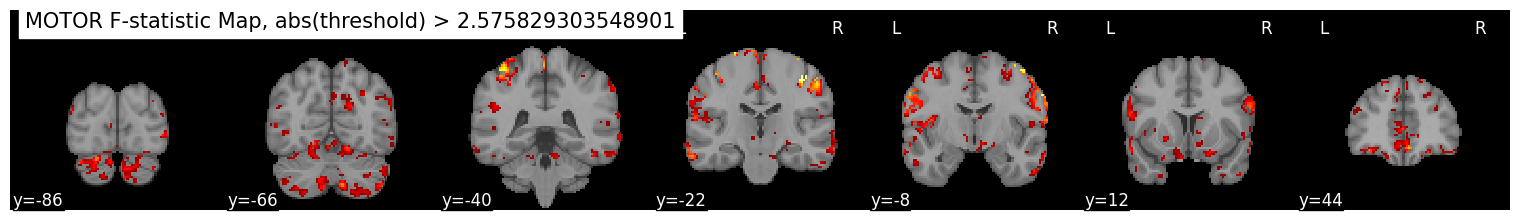

In [42]:
show_task_activation(subject, "MOTOR", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

processing subject gray matter mask
concatenating volumes for task GAMBLING
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_GAMBLING_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_GAMBLING_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_GAMBLING_RL.mat
fitting GLM for task GAMBLING
computing fmap


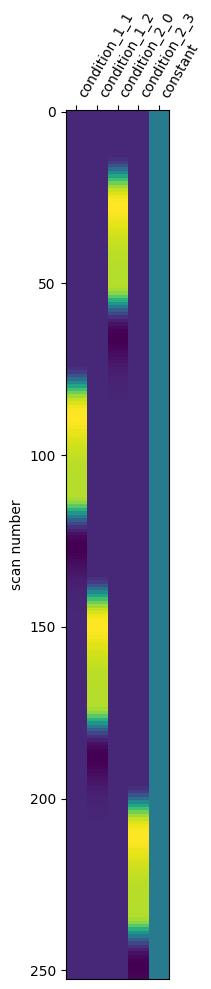

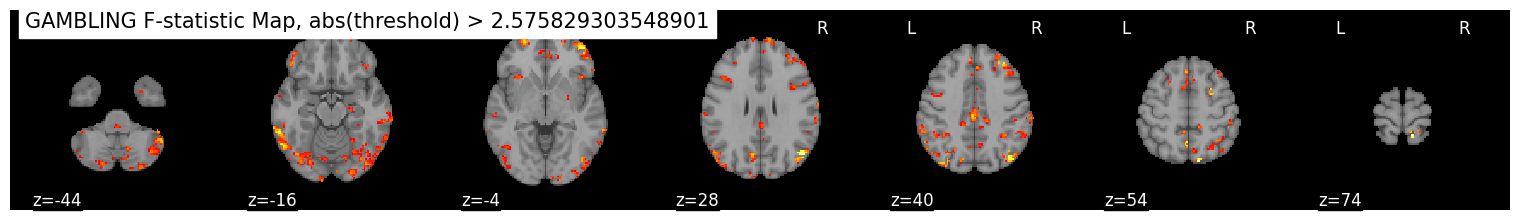

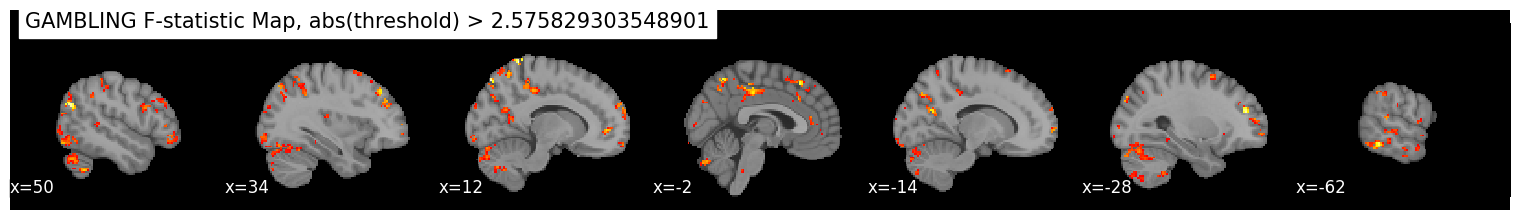

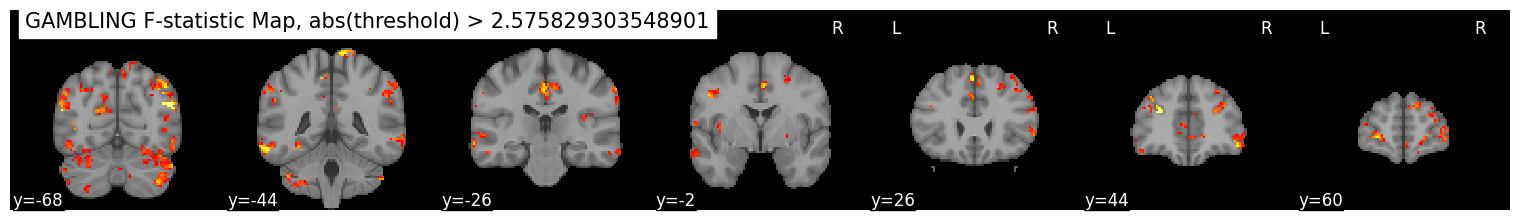

In [211]:
show_task_activation(subject, "GAMBLING", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

processing subject gray matter mask
concatenating volumes for task WM
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_WM_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_WM_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_WM_RL.mat
fitting GLM for task WM
computing fmap


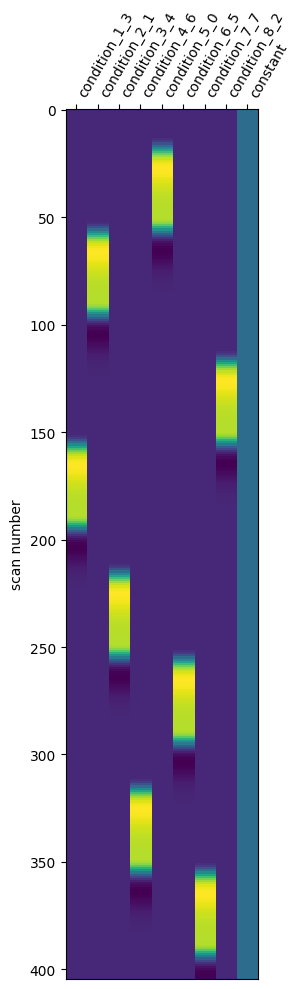

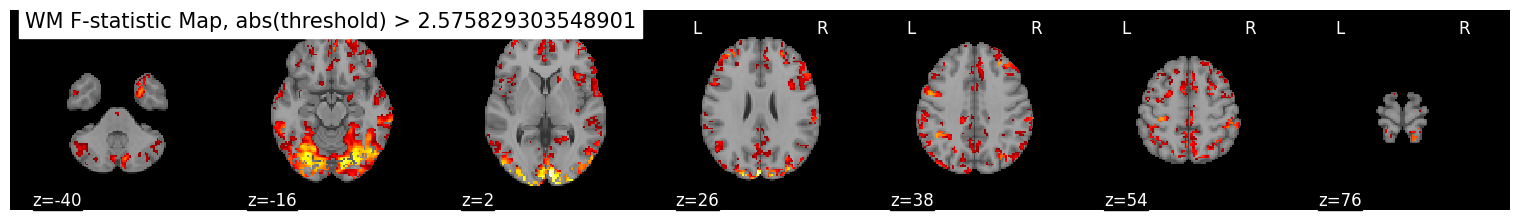

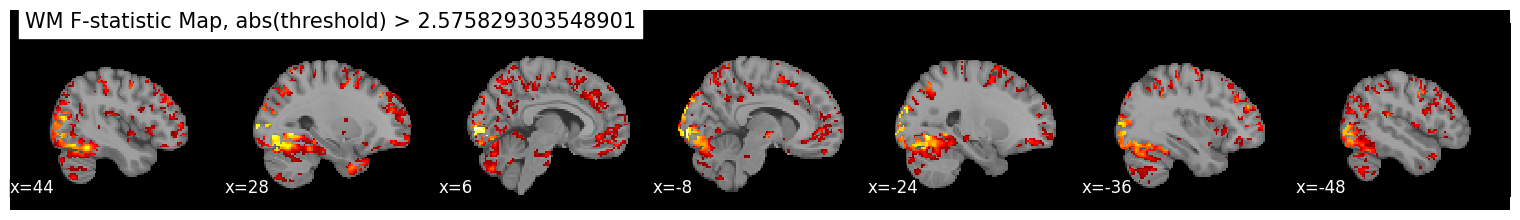

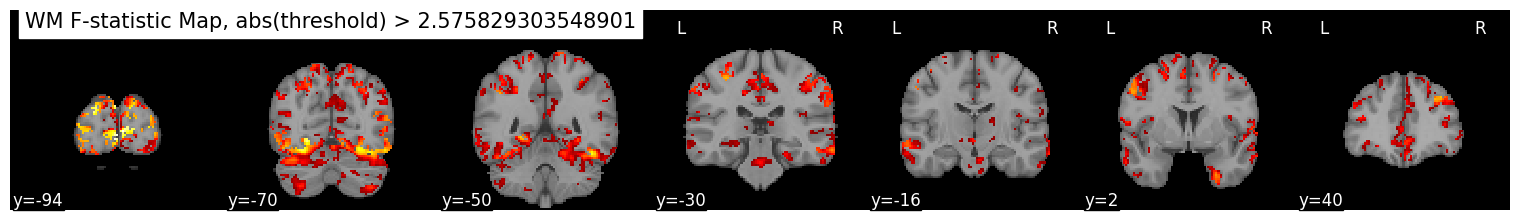

In [209]:
show_task_activation(subject, "WM", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

processing subject gray matter mask
concatenating volumes for task EMOTION
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_EMOTION_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_EMOTION_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_EMOTION_RL.mat
fitting GLM for task EMOTION
computing fmap


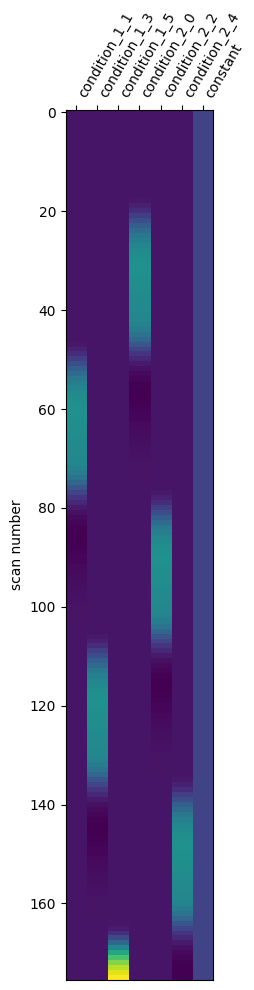

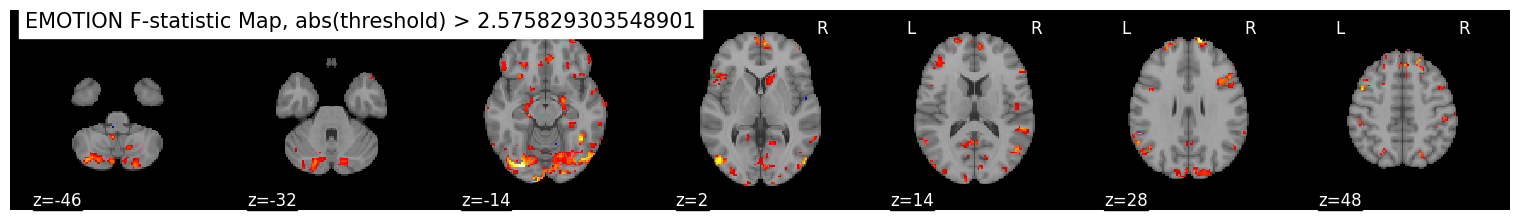

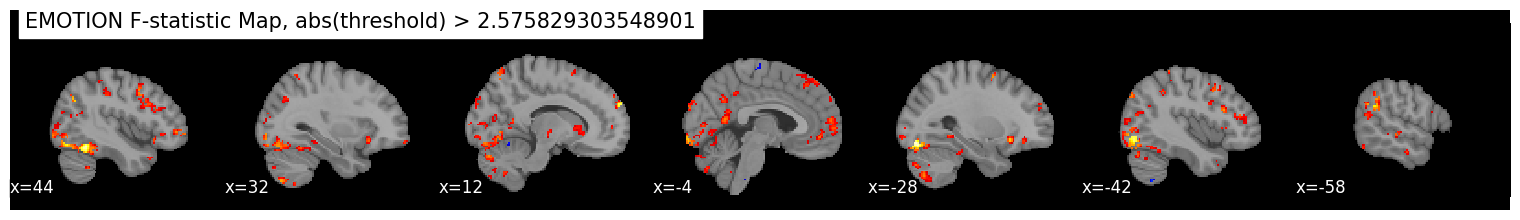

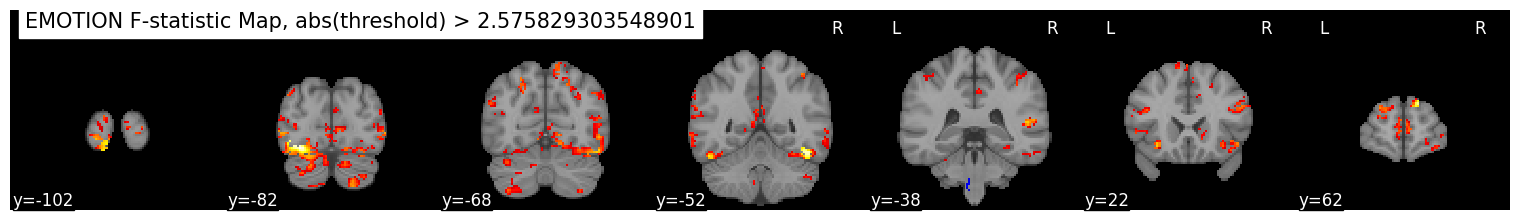

In [212]:
show_task_activation(subject, "EMOTION", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

processing subject gray matter mask
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


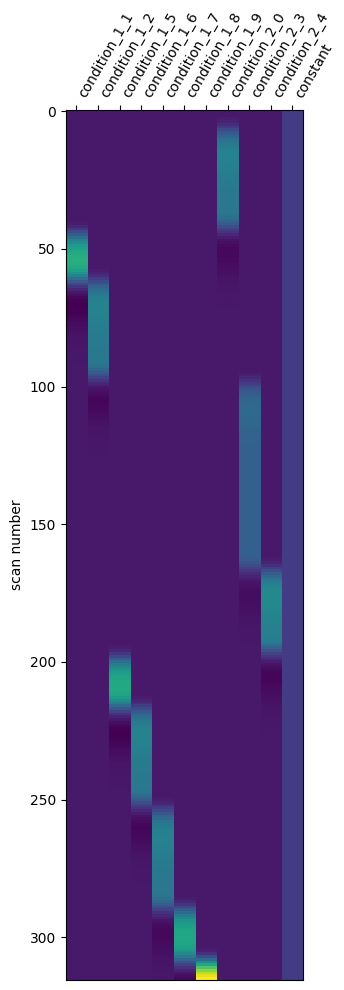

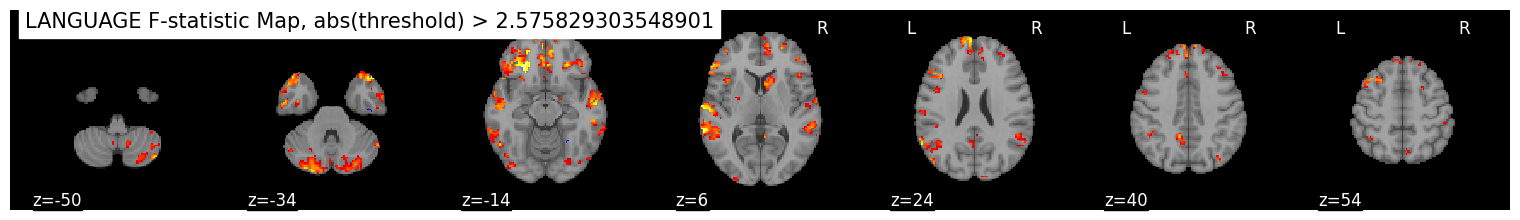

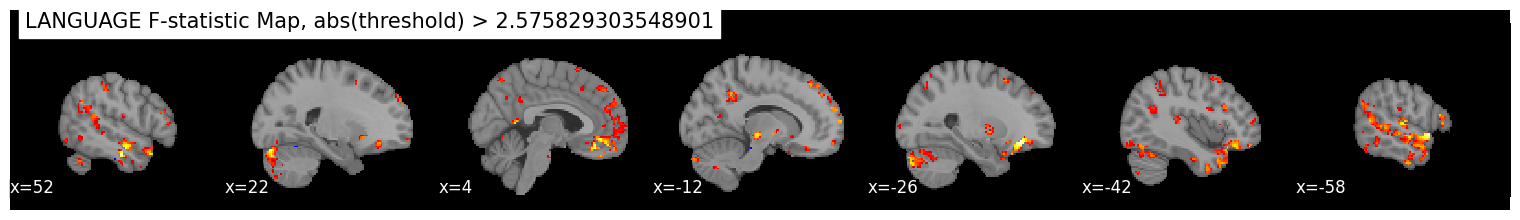

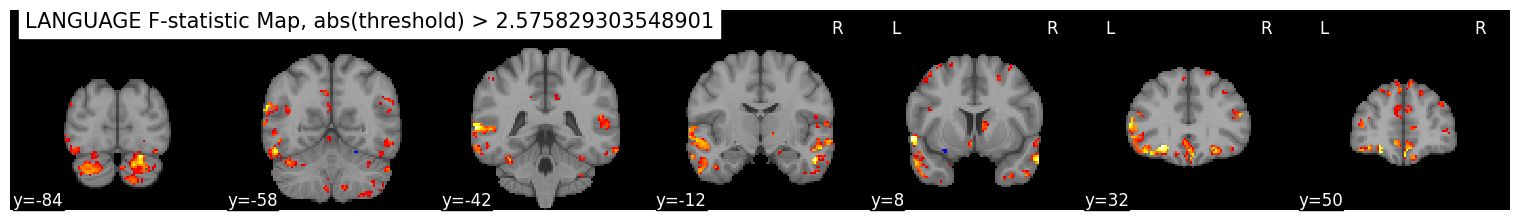

processing subject gray matter mask
concatenating volumes for task RELATIONAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_RELATIONAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_RELATIONAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_RELATIONAL_RL.mat
fitting GLM for task RELATIONAL
computing fmap


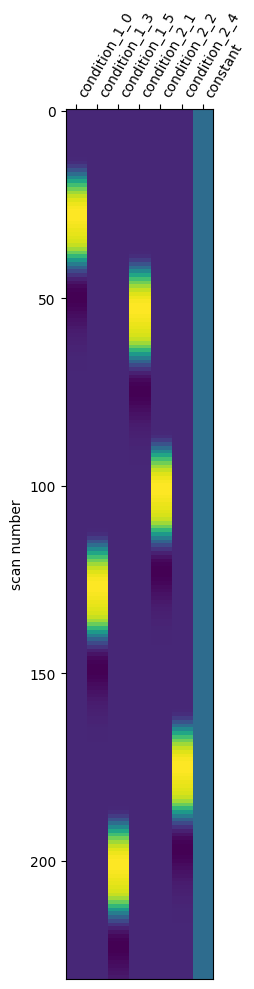

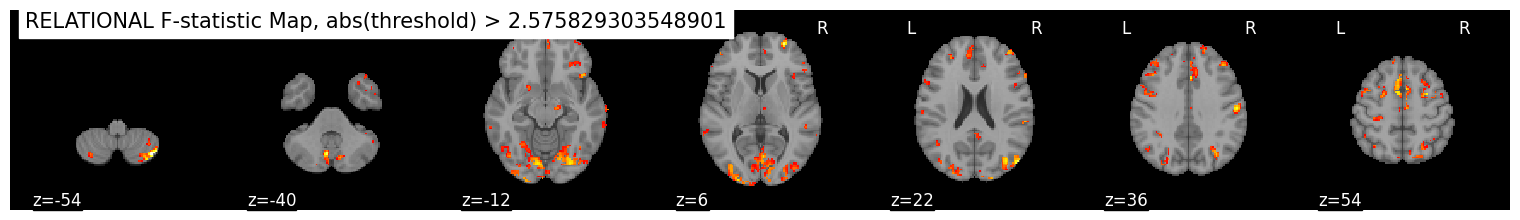

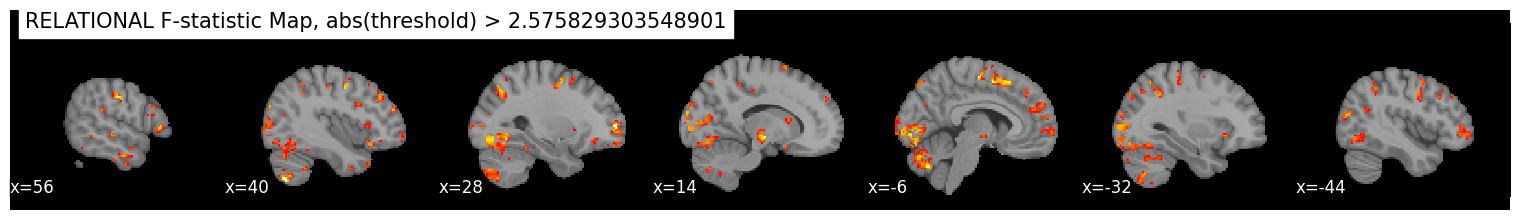

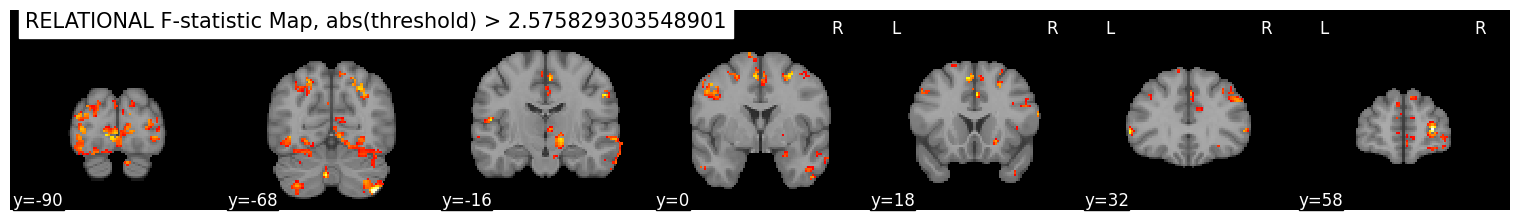

processing subject gray matter mask
concatenating volumes for task SOCIAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat
fitting GLM for task SOCIAL
computing fmap


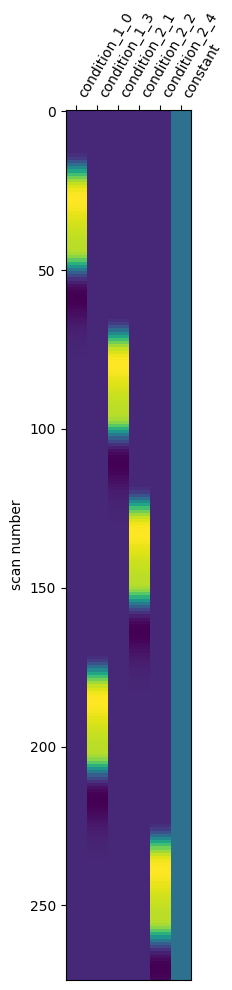

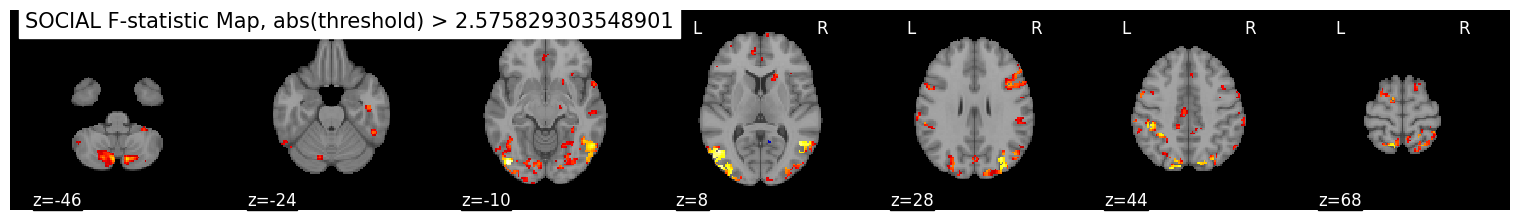

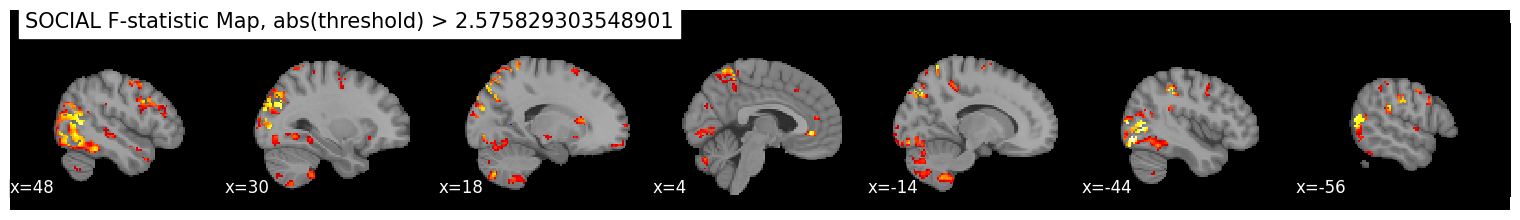

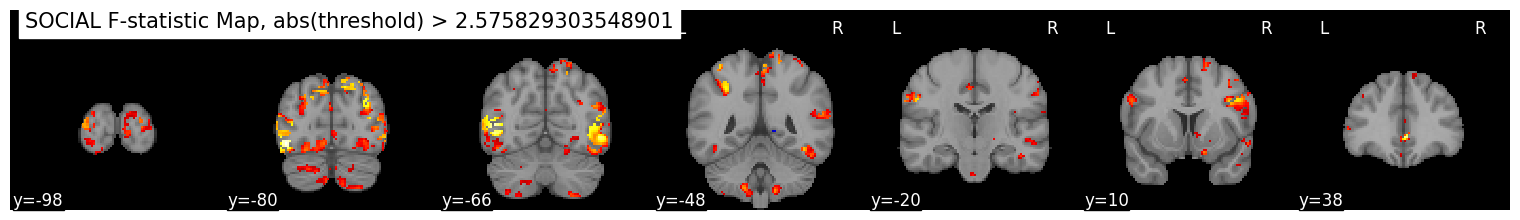

In [213]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)
show_task_activation(subject, "RELATIONAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)
show_task_activation(subject, "SOCIAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

In [ ]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10, fdr_rate=0.05)

processing subject gray matter mask
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE


/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat


onset  duration     trial_type
0    0.00     25.20  condition_2_0
1   27.36     11.52  condition_1_1
2   39.60     24.48  condition_1_2
3   66.24     48.24  condition_2_3
4  115.20     20.88  condition_2_4
5  138.24     12.24  condition_1_5
6  151.20     24.48  condition_1_6
7  177.84     25.20  condition_1_7
8  203.76     12.96  condition_1_8
9  217.44     12.24  condition_1_9

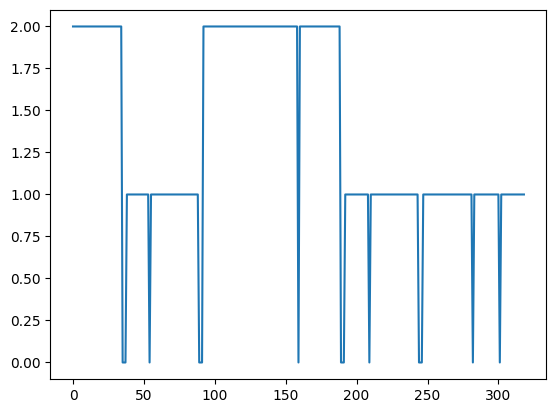

In [43]:
create_events_df(subject, "LANGUAGE", acquisition, plot_regressors=True)

processing subject gray matter mask
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-6mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-6mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


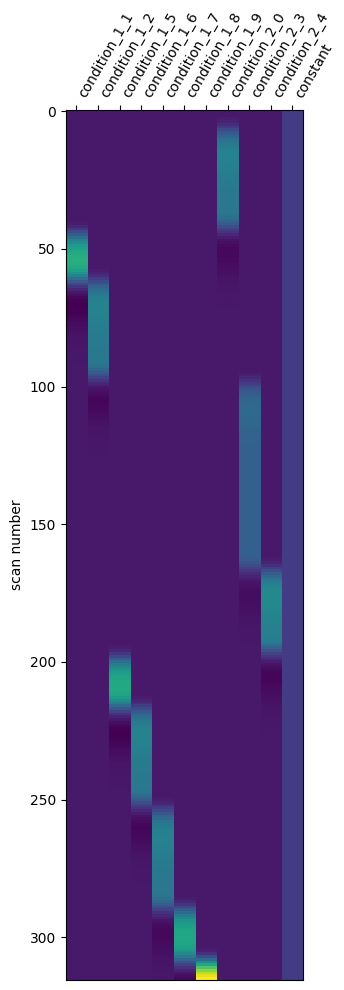

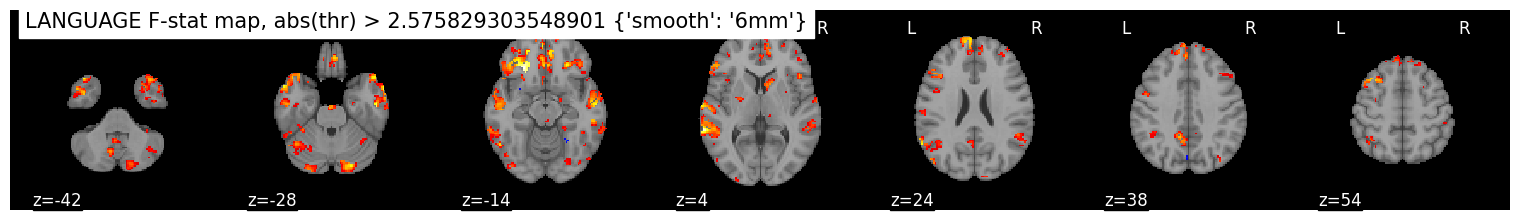

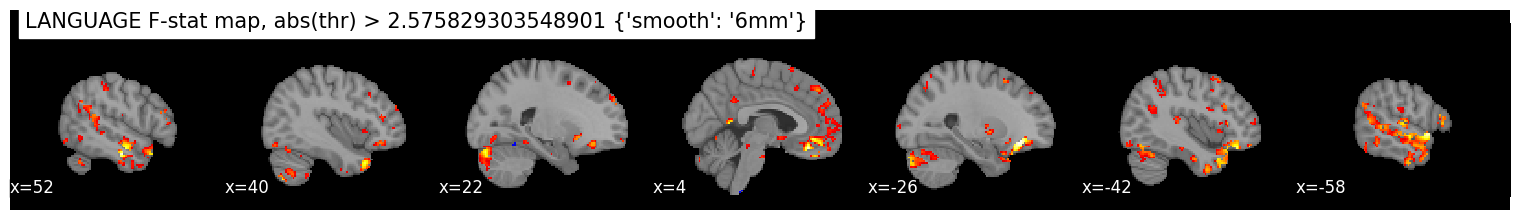

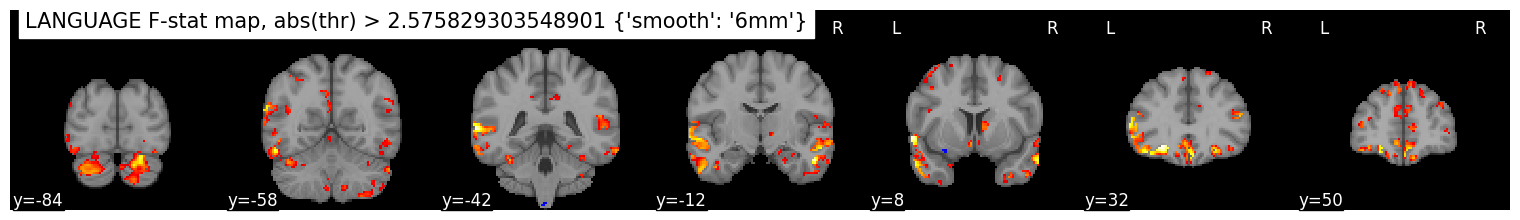

In [61]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=6, plot_designmatrix=True, cluster_size=10)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat


onset  duration     trial_type
0    7.92     22.32  condition_1_0
1   45.36     22.32  condition_2_1
2   83.52     22.32  condition_2_2
3  121.68     22.32  condition_1_3
4  159.84     22.32  condition_2_4

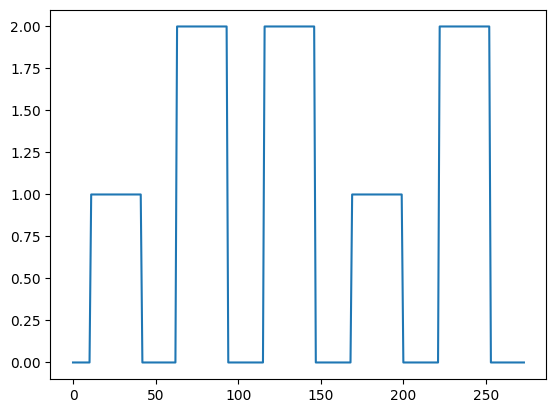

In [44]:
create_events_df(subject, "SOCIAL", acquisition, plot_regressors=True)

processing subject gray matter mask
concatenating volumes for task SOCIAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat
fitting GLM for task SOCIAL
computing fmap


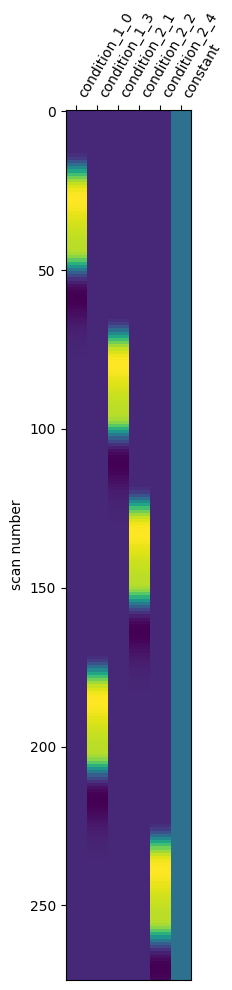

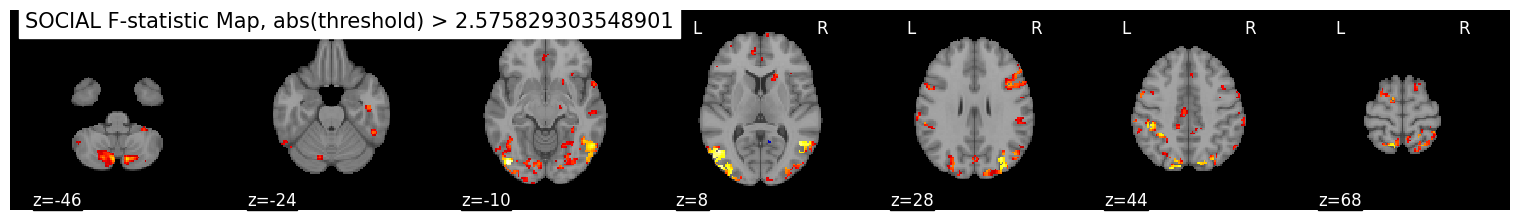

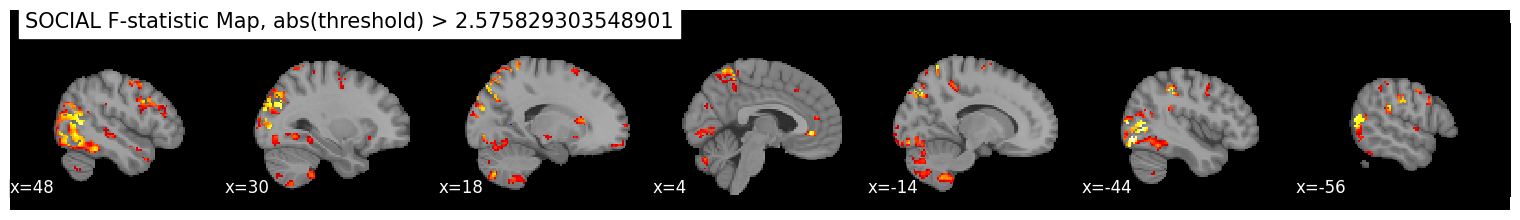

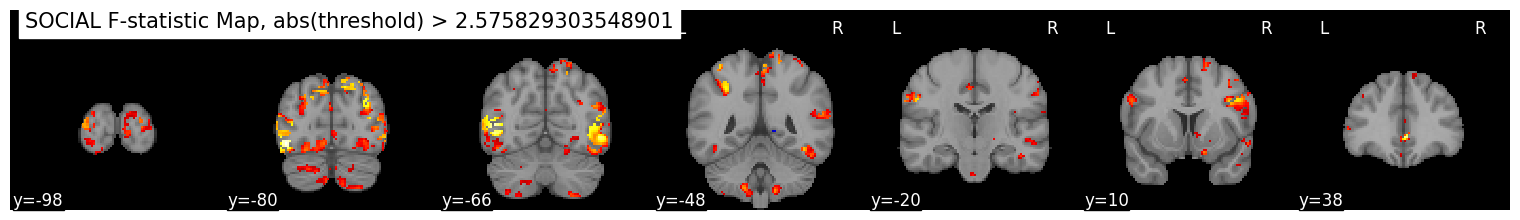

In [45]:
show_task_activation(subject, "SOCIAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

# 4 random subjects

In [63]:
subjects = [131722, 414229, 130013, 126325, 130316]

## motor

In [87]:
process_gray_matter_mask(anat_dir, "131722", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "414229", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "130013", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "126325", border_size=5, save=True, plot=False)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz


/home/federico/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: mask for 126325 was never extracted
  """


/home/federico/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: mask for 130316 was never extracted
  """


/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz


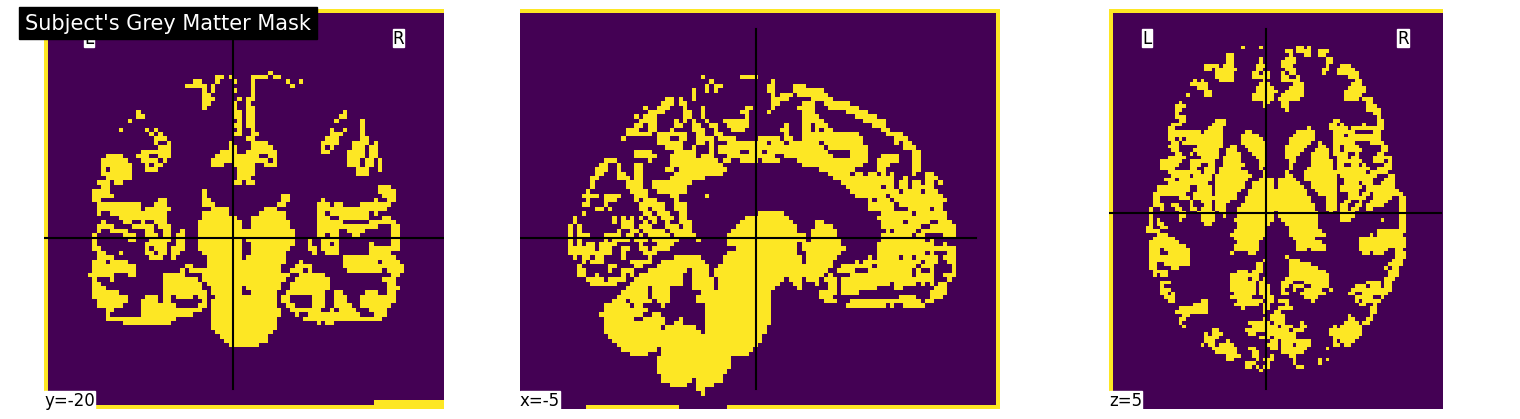

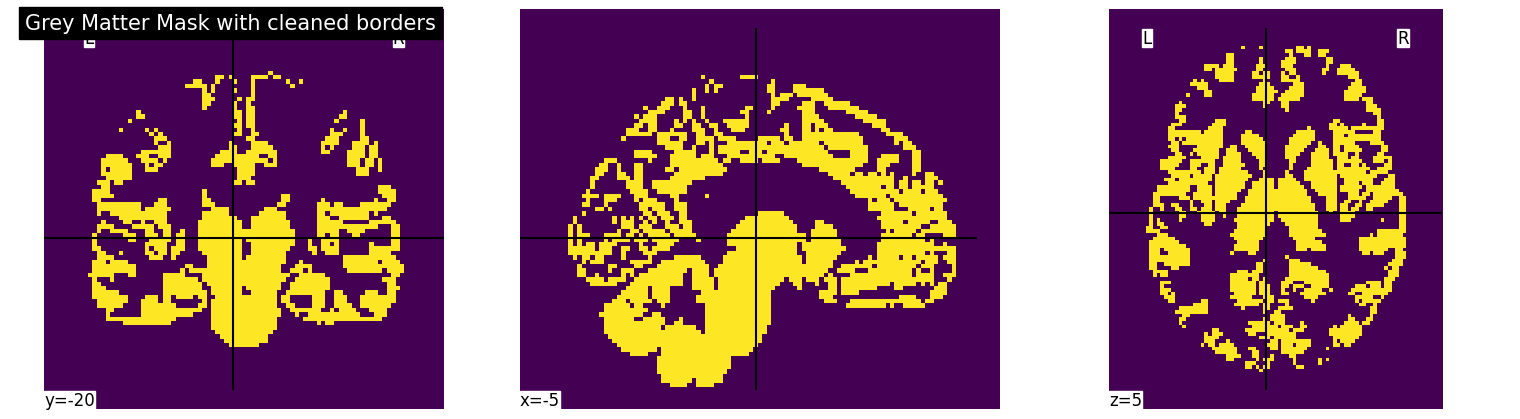

In [88]:
process_gray_matter_mask(anat_dir, "130316", border_size=5, save=False, plot=True)

In [89]:
process_gray_matter_mask(anat_dir, "130316", border_size=5, save=True, plot=False)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz


/home/federico/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: mask for 130316 was never extracted
  """


selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/131722_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/131722/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/131722/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/131722_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


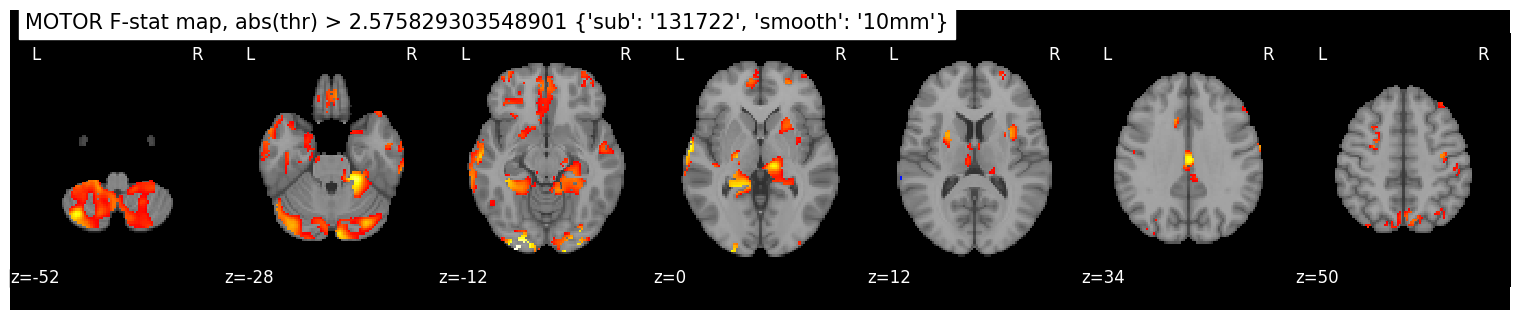

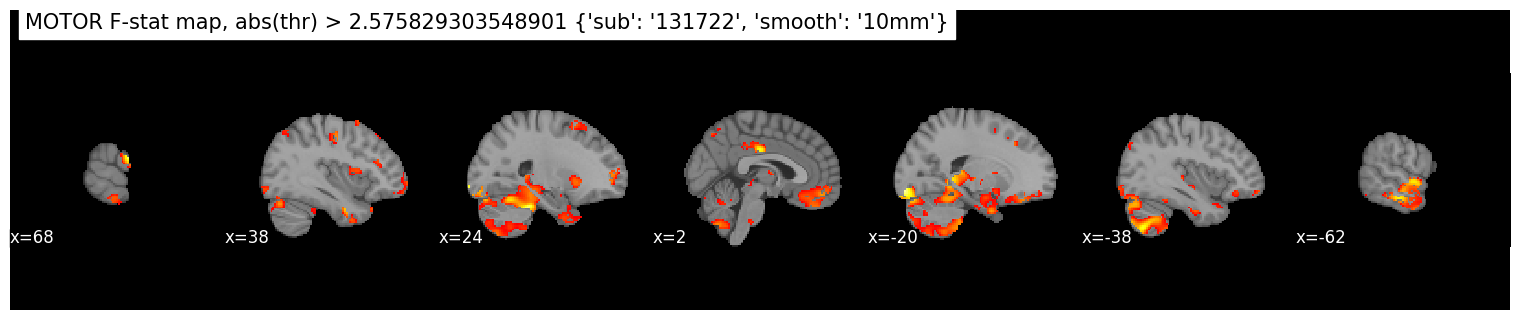

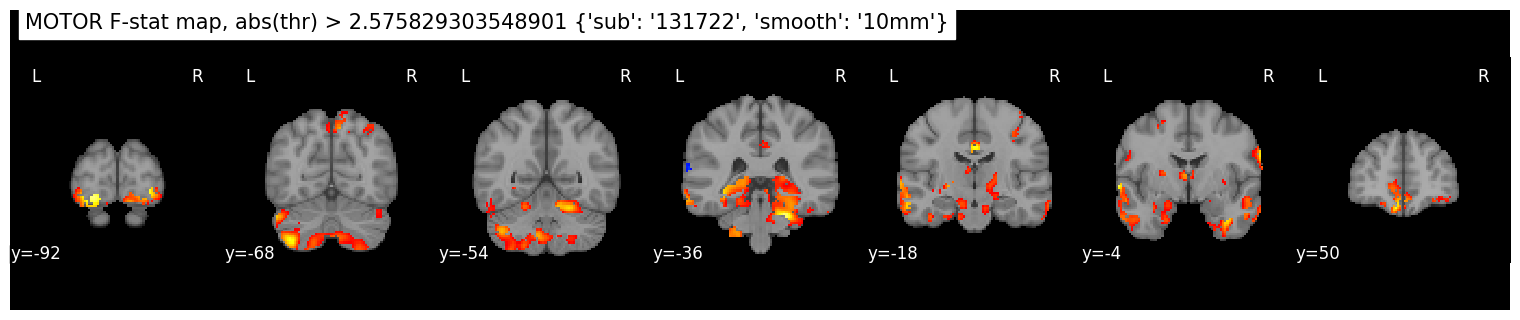

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/414229_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/414229/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/414229/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/414229_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


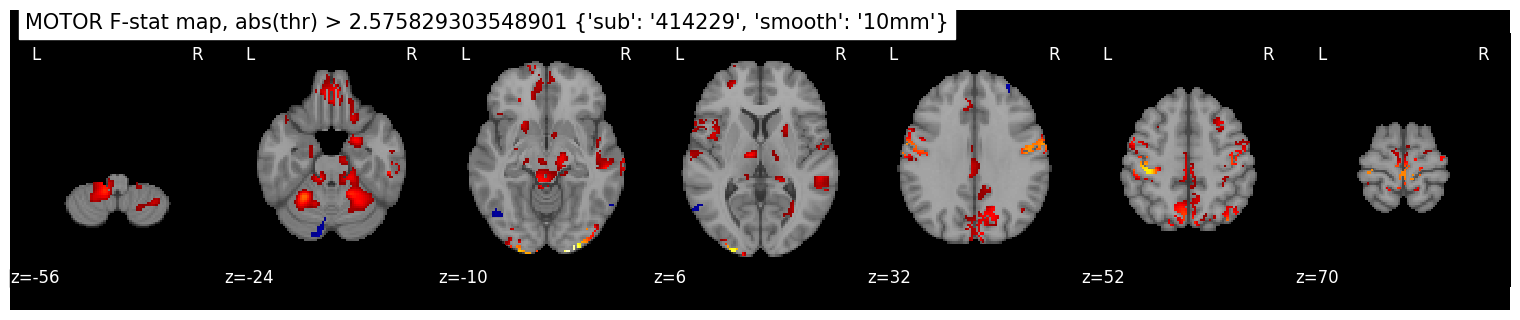

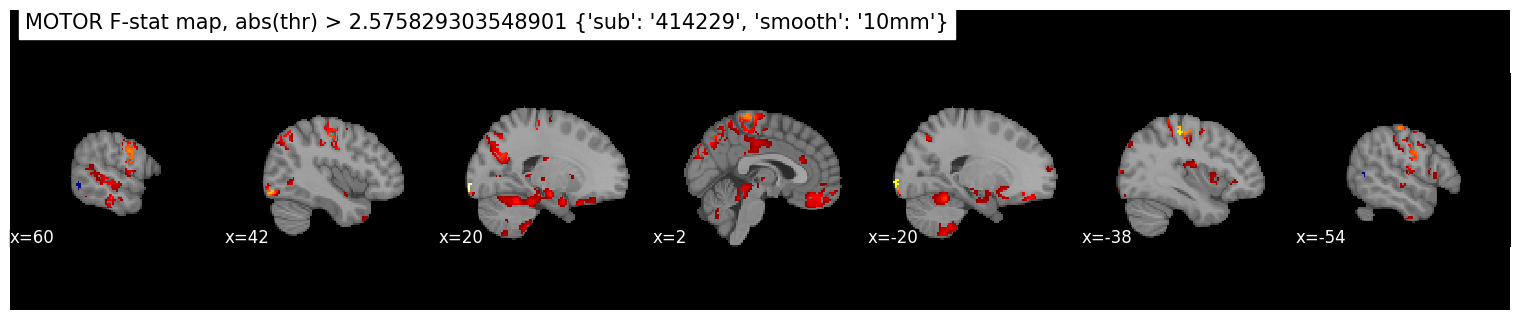

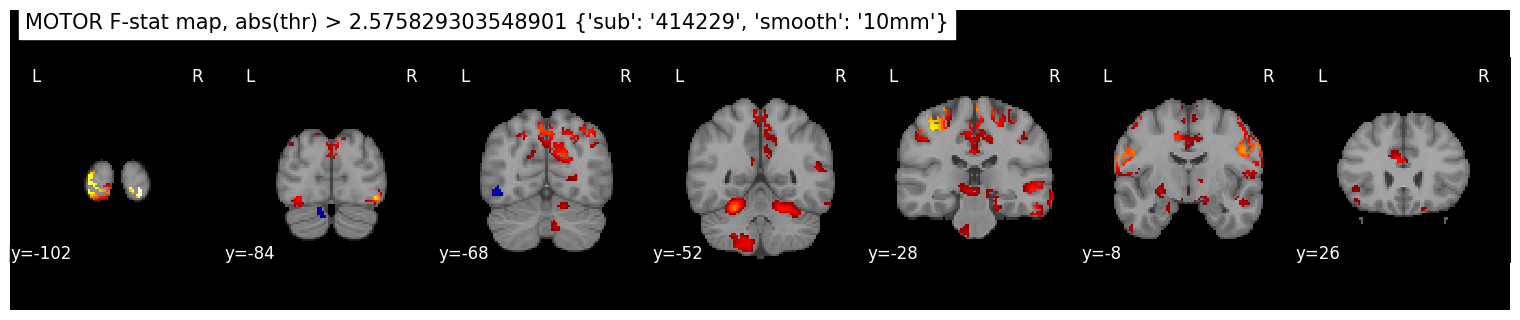

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130013_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130013/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130013/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130013_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


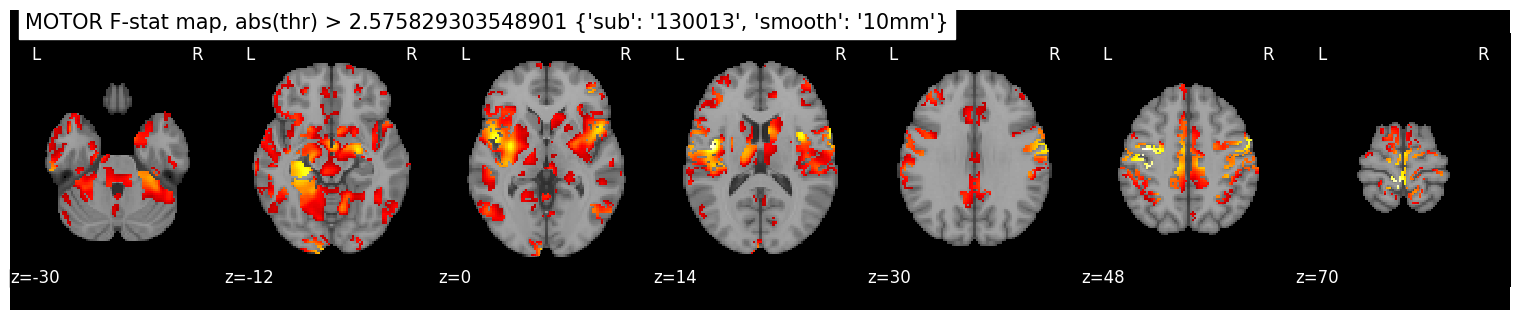

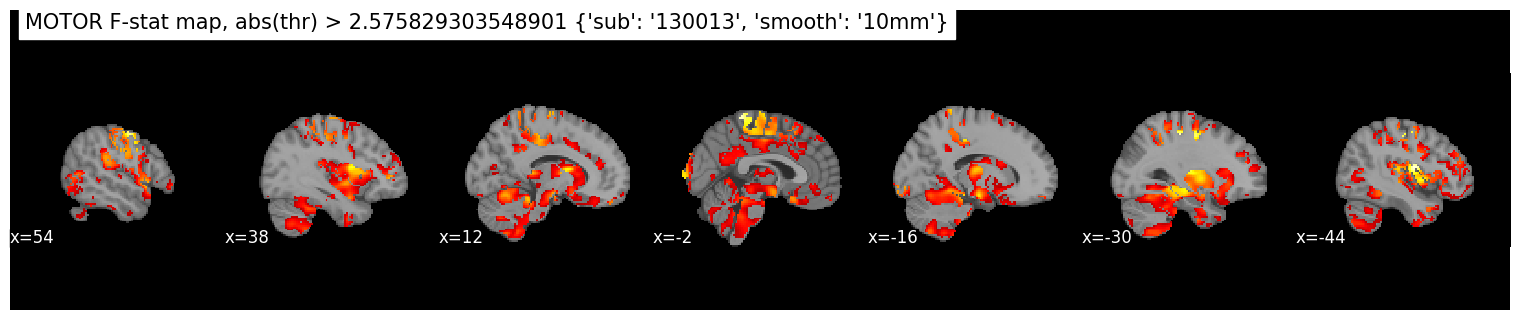

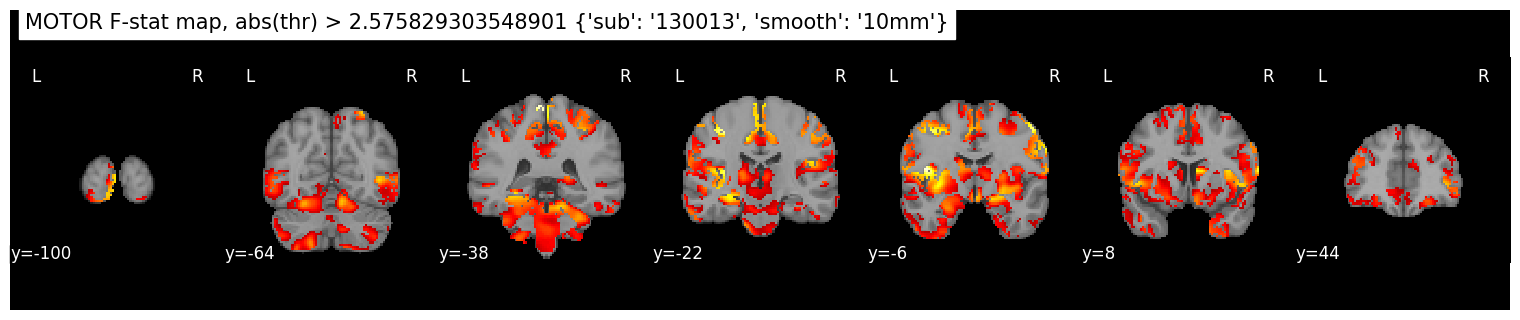

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/126325_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/126325/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/126325/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/126325_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


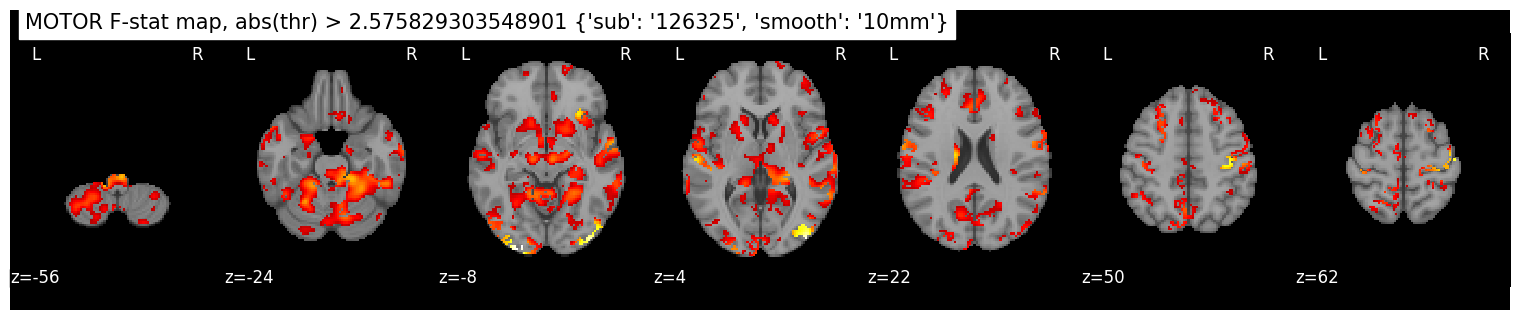

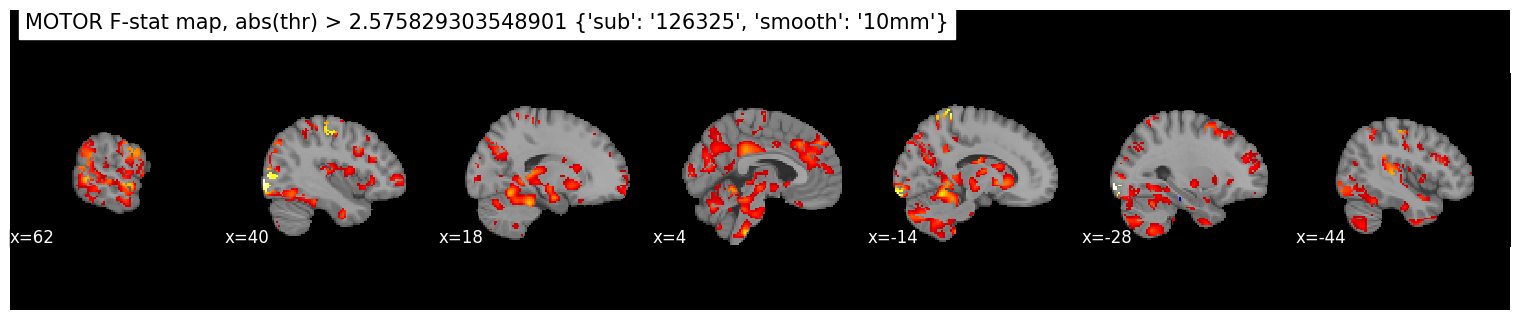

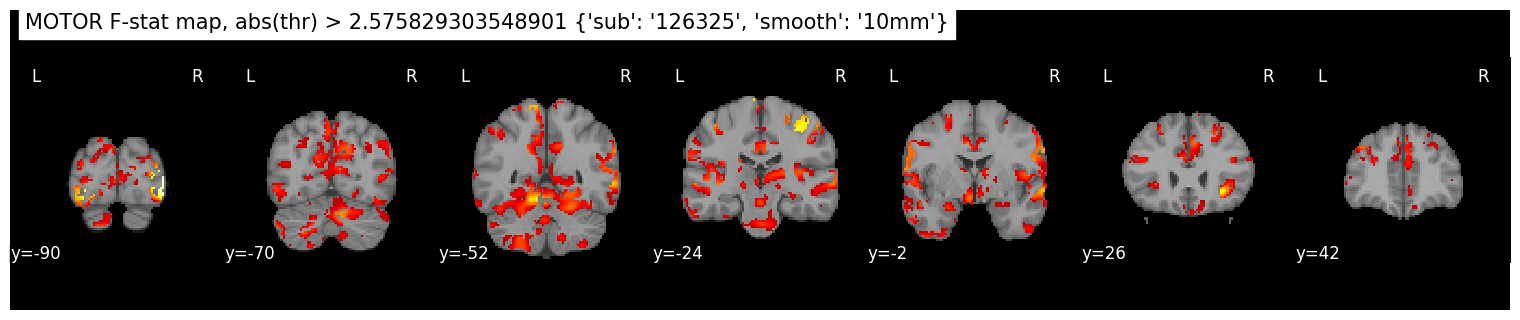

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130316_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130316/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130316/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130316_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap


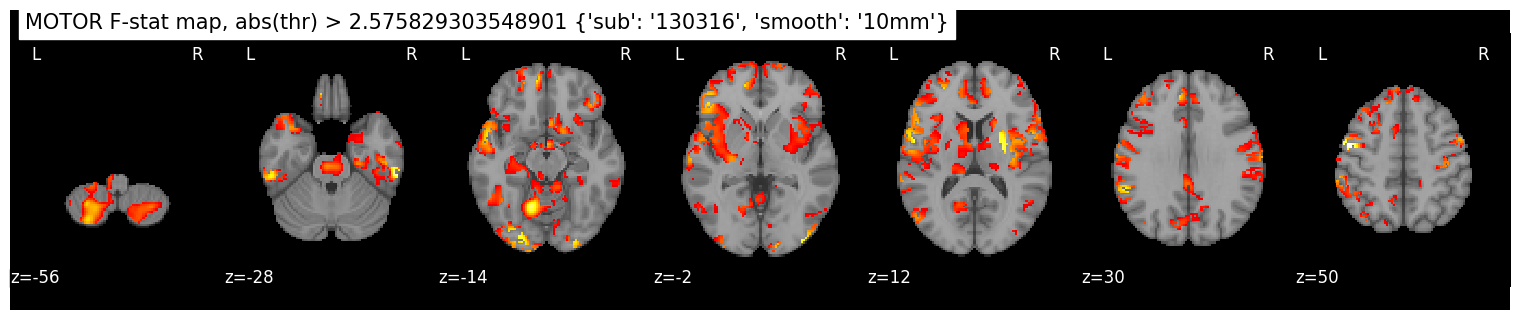

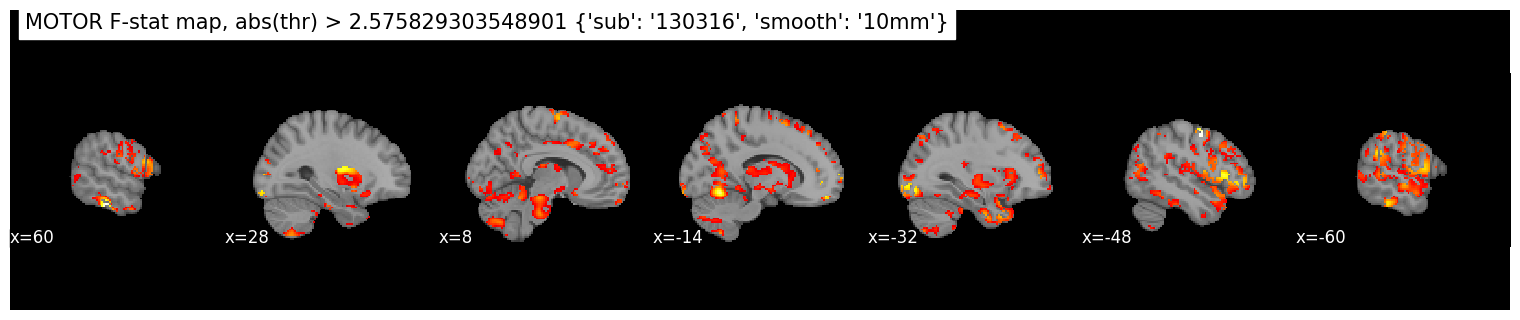

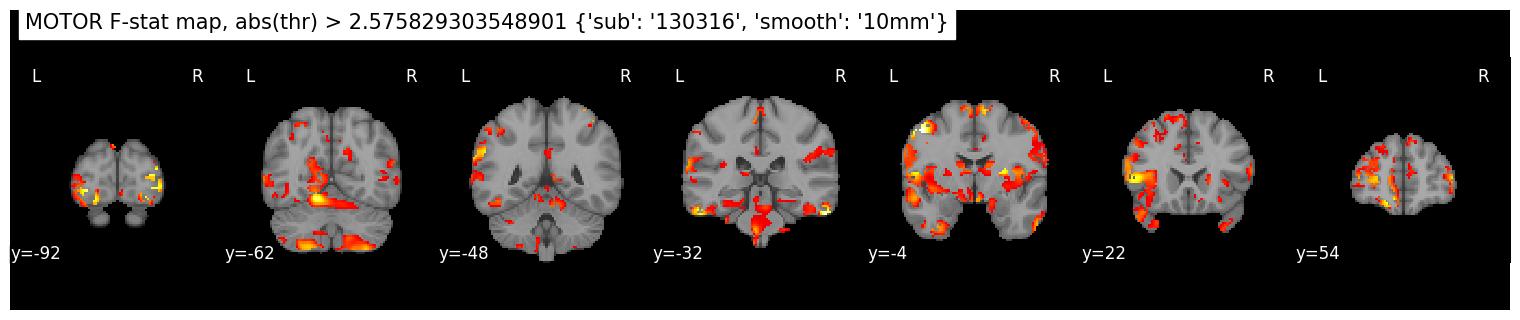

In [104]:
for subject in subjects:
    show_task_activation(f"{subject}", "MOTOR", acquisition, smoothing=10, plot_designmatrix=False, cluster_size=15, plot_glass=False)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/131722_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/131722/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/131722/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/131722_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


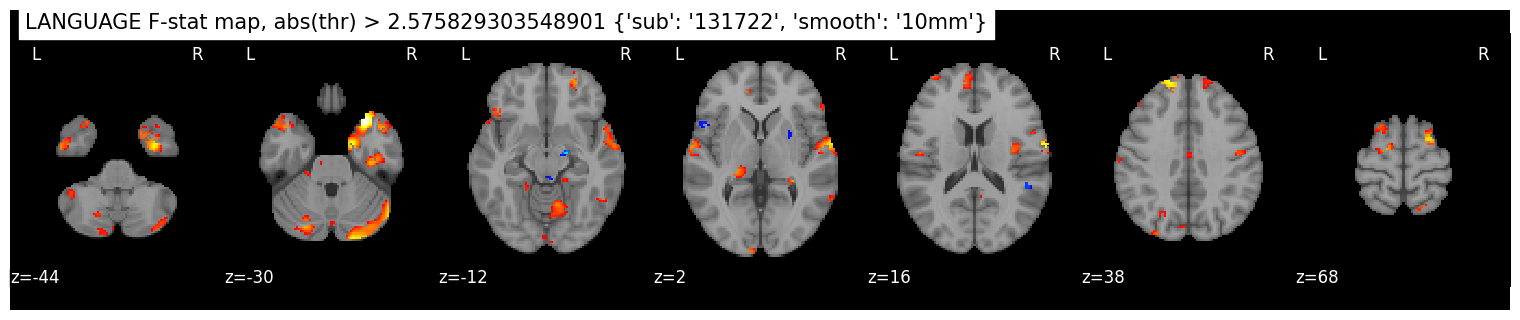

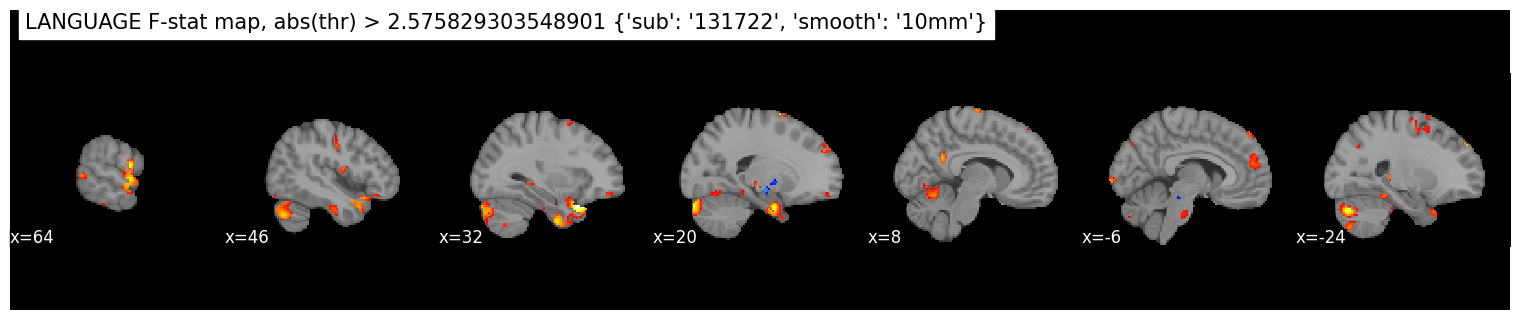

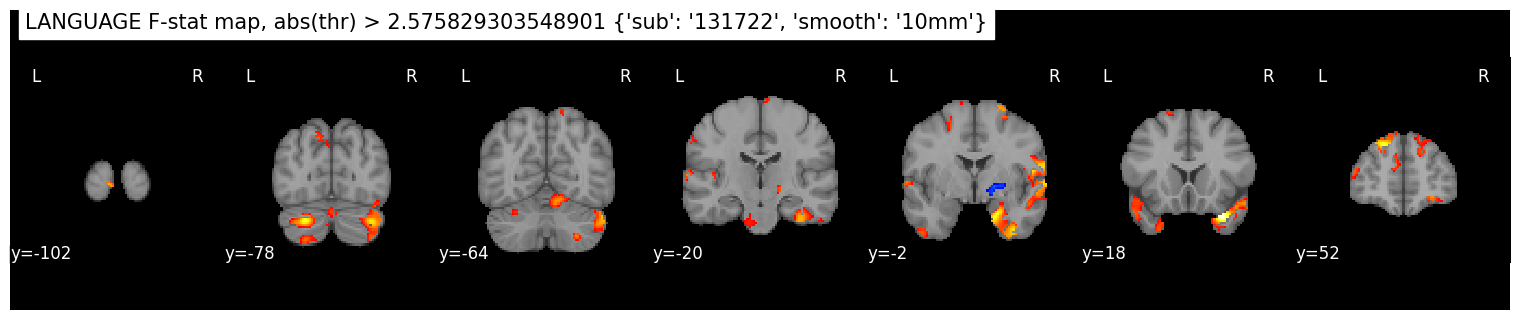

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/414229_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/414229/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/414229/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/414229_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


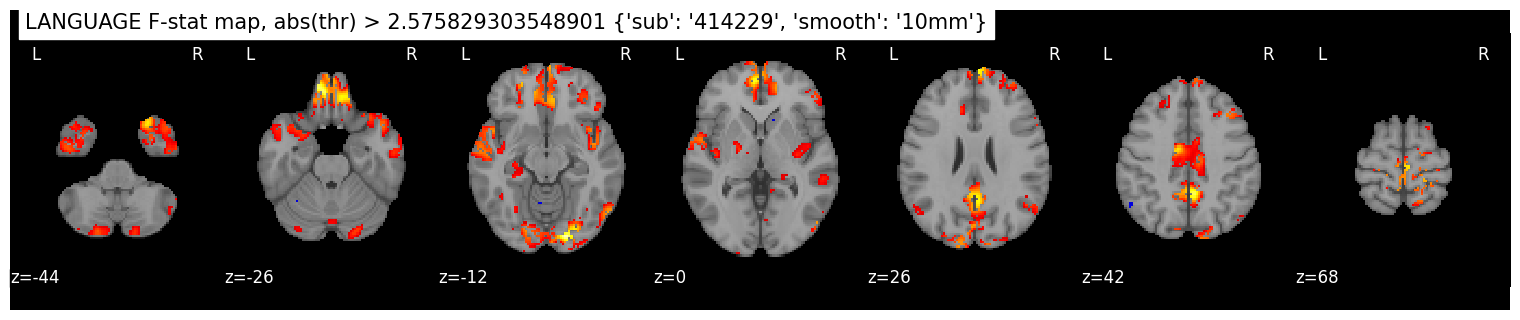

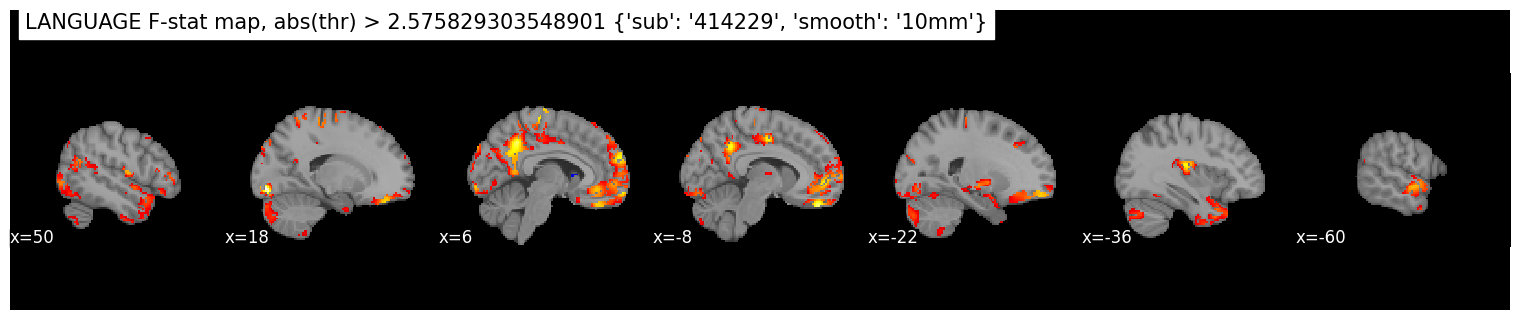

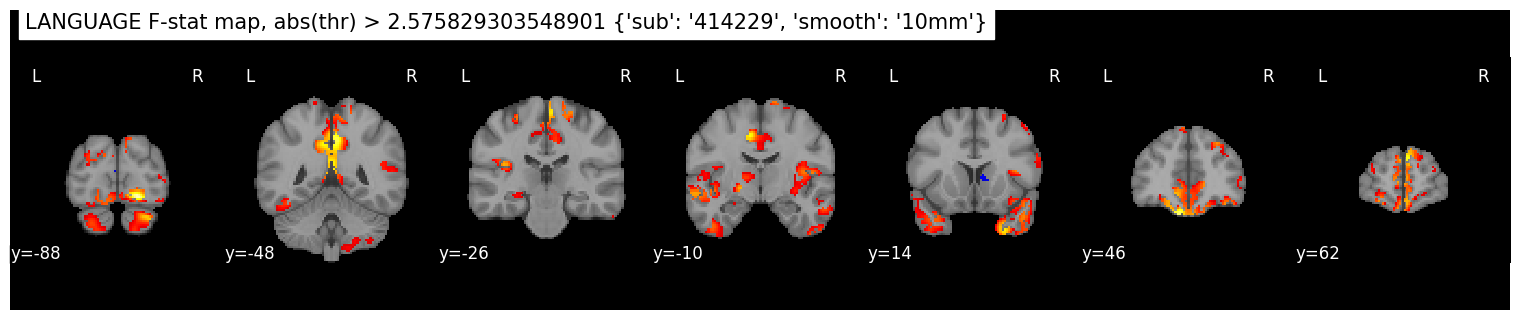

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130013_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130013/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130013/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130013_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


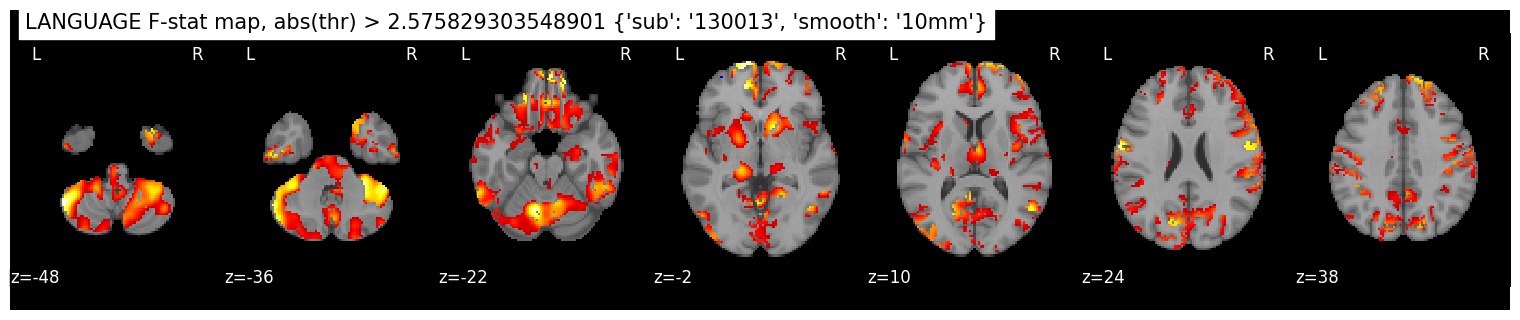

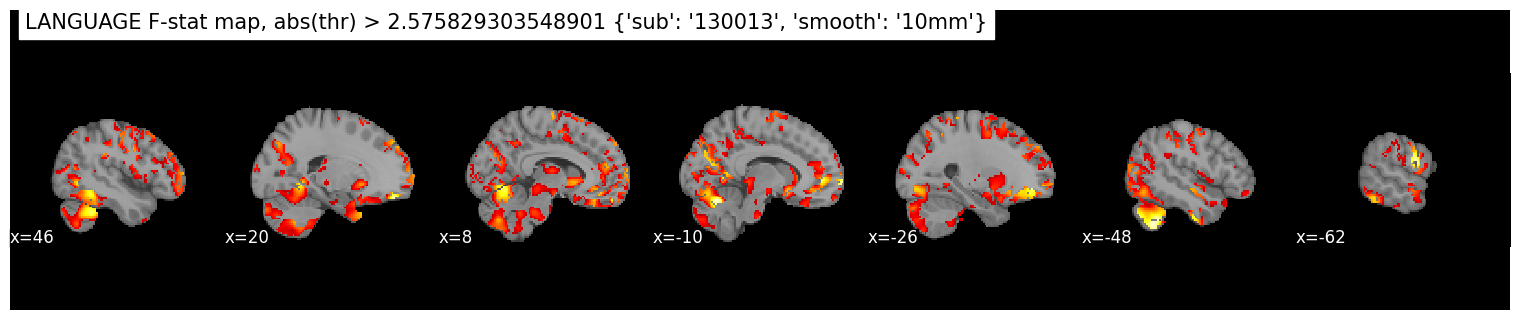

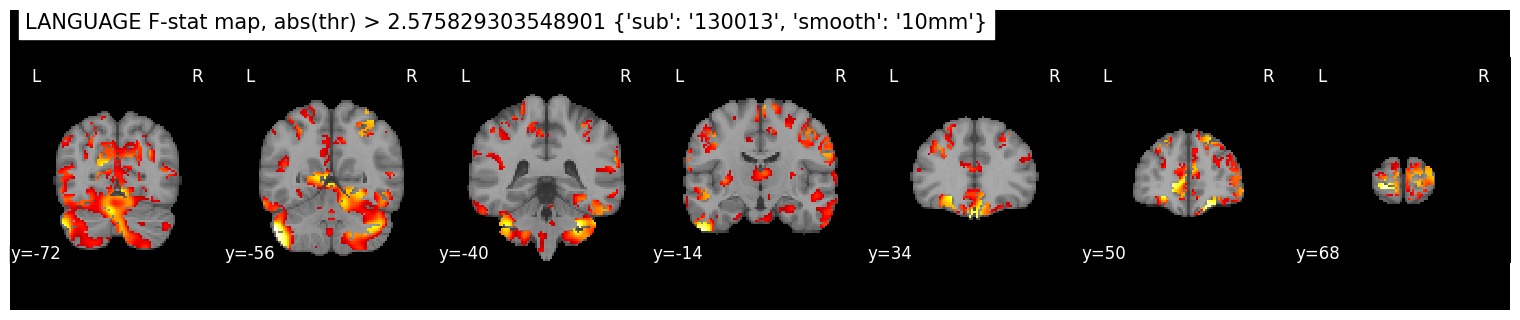

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/126325_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/126325/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/126325/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/126325_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


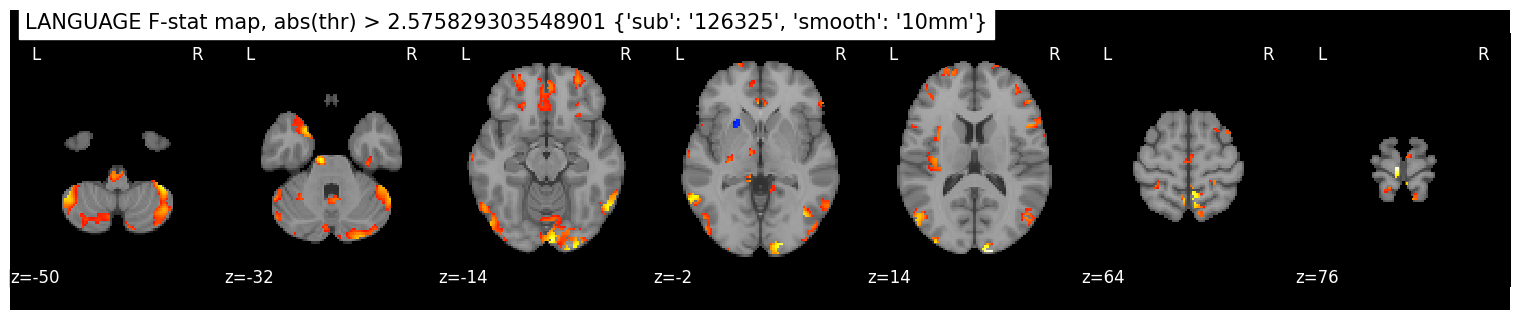

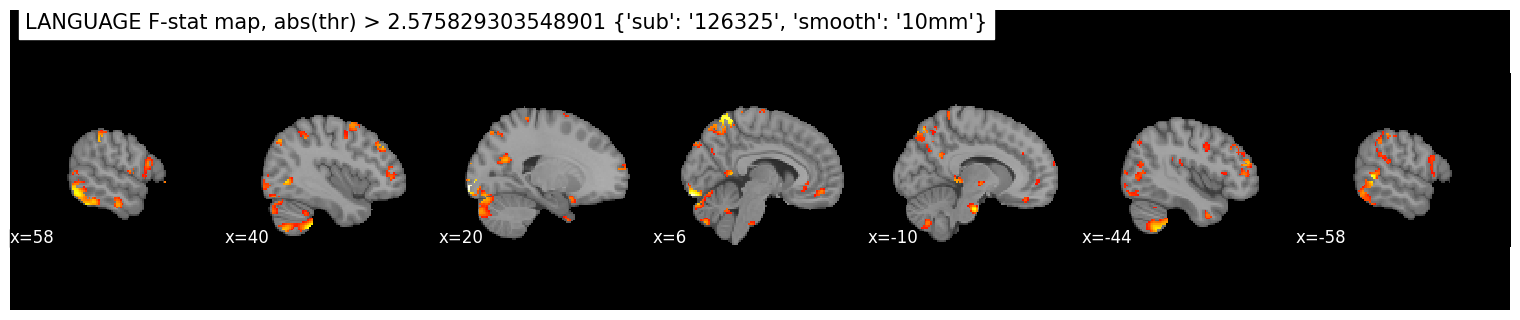

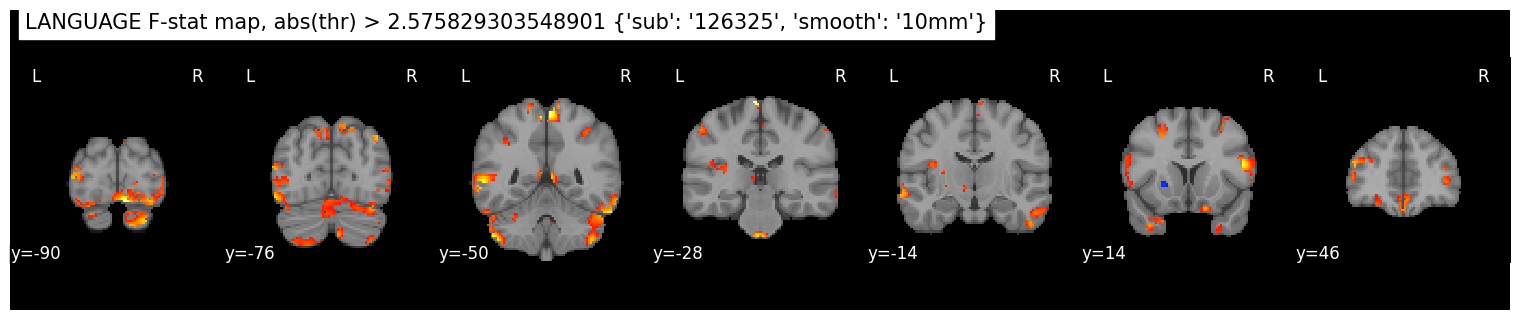

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130316_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130316/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/130316/tfMRI_LANGUAGE_RL/fMRIvols_GLMyes/Cov_ftfMRI_LANGUAGE_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130316_Regressor_tfMRI_LANGUAGE_RL.mat
fitting GLM for task LANGUAGE
computing fmap


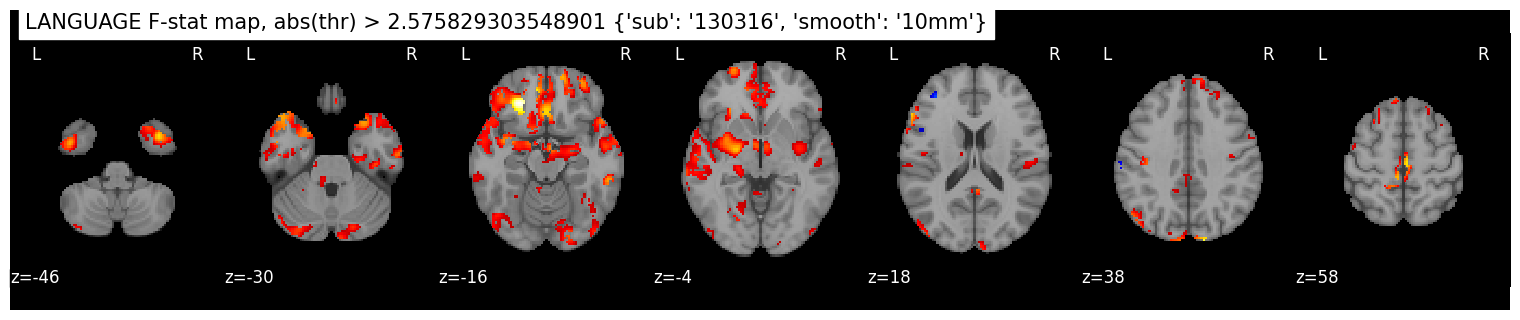

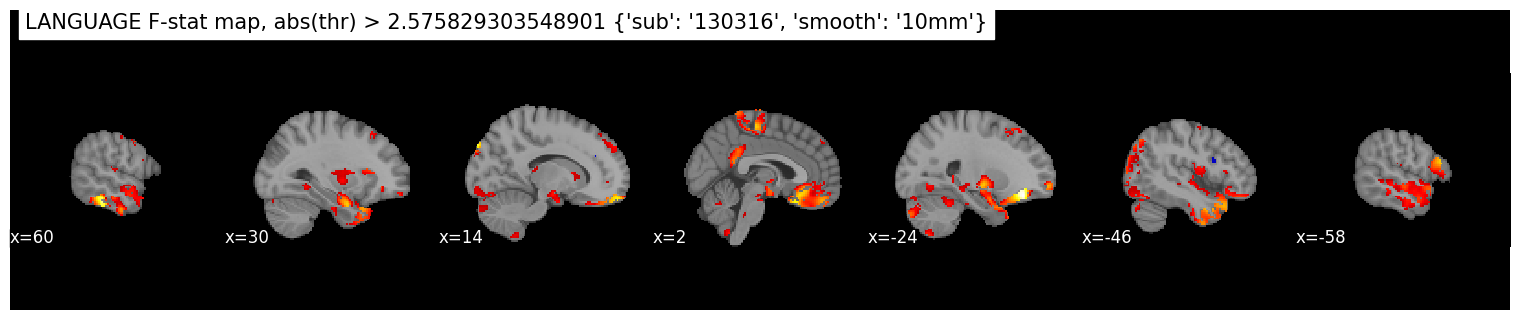

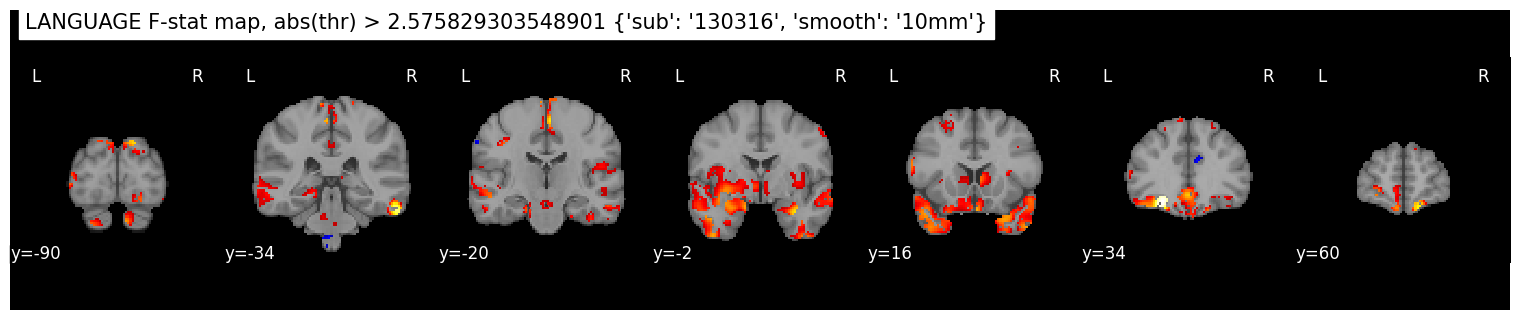

In [105]:
for subject in subjects:
    show_task_activation(f"{subject}", "LANGUAGE", acquisition, smoothing=10, plot_designmatrix=False, cluster_size=15, plot_glass=False)